In [1]:
# importing the necessary python modules

# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# we want matplotlib to display the text with a LaTeX backend
plt.rcParams['text.usetex'] = True

# scipy is an extension for numpy, used extensively in scientific computing
from scipy.sparse import linalg
from scipy.sparse import lil_matrix, csc_matrix
from scipy import stats

# here we import the functions translated from matlab
import Mesher
import Matrix
import PoroElasticProperties as prop

### Problem geometry
We want to model a fracture of fixed length $L$ in a homogeneous medium. The wellbore is considered too small compared to the extent of the fracture so we will not model it. We will simplify the problem using it's symmetry around the fracture, only modelling the upper quadrant of the domain.

![alt text](fracture.svg)



Refined mesh contains 851 nodes


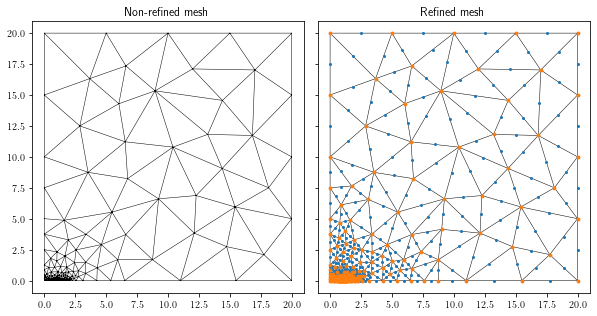

In [2]:
plt.close('all')
# We define the geometry of the problem

# The fracture will be of length 1 and the domain will be as large as 20 times the fracture length
frac_length = 1.0
box_length = 20 * frac_length

# stresses are highly singular at the tip of the fracture, showing high gradients
# therefore we need to discretize it with a very careful approach

# first we discretize it linearly with a few points
n0 = 21
vertices = np.linspace(0, 2*frac_length, n0)

# using the package scipy.stats we can define our own density for the discretisation of the fracture
# a normal density centered around the fracture tip will provide the finess needed to model the high gradients at this point
nnorm = 15
dist = stats.norm(loc=frac_length, scale=0.2*frac_length)
bounds = dist.cdf([0, 2*frac_length])
pp = np.linspace(*bounds, nnorm)
norm_vertices = dist.ppf(pp)
norm_vertices = norm_vertices.round(decimals=5)
vertices = np.unique(np.sort(np.hstack((vertices, norm_vertices))))

vertices = np.vstack((vertices, 0*vertices)).T
other_vertices = np.array([[box_length, 0],
                           [box_length, box_length],
                           [0, box_length],
                           ])

vertices = np.vstack((vertices, other_vertices))#, np.roll(vertices[1:], shift=1, axis=1)[::-1]))

# the Mesher.py file contains functions to deal with easy meshing, akin to the matlab code
edges = Mesher.build_edges(vertices)
area = 10
mesh3 = Mesher.Mesh(vertices, edges, cell_size=area)  # Mesher.Mesh is the main object, created with similar arguments

# we can refine the mesh by giving a box as input to the Mesh object with the Mesh.refine() function
bbox = np.array([[0, 0],
                 [0, frac_length],
                 [frac_length, frac_length],
                 [frac_length, 0]])
# the Mesh.plot() function can easily plot the mesh's shape, also assigning it a matplotlib Axis object 
fig, axs = plt.subplots(1, 2, sharex='row', sharey='row', figsize=(10, 8))
mesh3.plot(ax=axs[0])
axs[0].set_title('Non-refined mesh')

# we can refine the mesh as is, updating it in place
mesh3.refine(5*bbox, area=0.5)

# finally, we convert the linear elements to quadratic elements, greatly augmenting the number of nodes
mesh = Mesher.tri3_2_tri6(mesh3)

# what does the refined mesh look like?
mesh.plot(ax=axs[1])
axs[1].scatter(mesh.nodes[:, 0], mesh.nodes[:, 1], s=4, zorder=10)
axs[1].scatter(mesh3.nodes[:, 0], mesh3.nodes[:, 1], s=8, zorder=15)
axs[1].set_title('Refined mesh')
axs[0].set_aspect(1)
axs[1].set_aspect(1)
fig.subplots_adjust(wspace=0.05)

print(f'Refined mesh contains {len(mesh.nodes)} nodes')

### Enforcing boundary conditions
We want to be able to enforce boundary conditions everywhere on the outer part of the domain. We need a logic to select those nodes on the left, right, top and bottom walls, also accounting for the fracture.

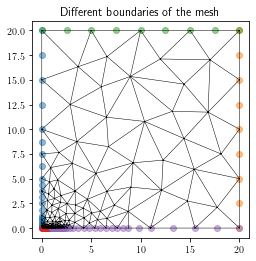

In [3]:
# we get the boundaries needed to enforce boundary conditions
left = np.argwhere(np.abs(mesh.nodes[:, 0] - mesh.nodes[:, 0].min()) <= 1e-4)[:, 0]
right = np.argwhere(np.abs(mesh.nodes[:, 0] - mesh.nodes[:, 0].max()) <= 1e-4)[:, 0]
top = np.argwhere(np.abs(mesh.nodes[:, 1] - mesh.nodes[:, 1].max()) <= 1e-4)[:, 0]

bottom = np.abs(mesh.nodes[:, 1] - mesh.nodes[:, 1].min()) <= 1e-4
frac = mesh.nodes[:, 0] < frac_length
bottom_frac = np.argwhere(bottom & frac)[:, 0]
bottom_clear = np.argwhere(bottom & ~frac)[:, 0]

mesh.plot()
for cond in (left, right, top, bottom_frac, bottom_clear):
    plt.scatter(*mesh.nodes[cond].T, alpha=0.5)

plt.title('Different boundaries of the mesh')
plt.gca().set_aspect(1)


### Definition of mechanical properties
Some mechanical properties are needed, some are not. Account for proper dimensional analysis

In [4]:

# definition of geomechanical properties
## would need to tweak the parameters a bit probably
k = 8.4e3  # elastic drained bulk modulus [MPa]
g = 6.8e3  # shear modulus [MPa]
alpha = 0.707692  # biot coefficient
M = 9.18478e3  # biot modulus [MPa]
k_u = prop.undrained_bulk_modulus(k, alpha, M)

# we can use those values and the PoroElasticProperties.py library to easily convert those values to Young's modulus and Poisson's ratio, in the undrained and drained case
nu_u = prop.poisson_ratio(g, k_u)  # undrained poisson ratio
E_u = prop.young_modulus(g, k_u)  # undrained yougn modulus

nu = prop.poisson_ratio(g, k)  # poisson ratio
E = prop.young_modulus(g, k)  # young modulus

# Finally, we set the conductivity $\kappa$ to this value so that c = k/(mu S) = 1 for simplicity
kappa = 1.38e-4  # m^2

"""g = 6.8e3  # Shear modulus, in MPa
k = 8.4e3  # Bulk modulus, in Mpa
alpha = 0.71  # Biot's coefficient, adimensional
m = 9.18e3  # Biot's modulus, in Mpa
k_u = prop.undrained_bulk_modulus(k, alpha, m) # Undrained bulk modulus, in MPa

# we can use those values and the PoroElasticProperties.py library to easily convert those values to Young's modulus and Poisson's ratio, in the undrained and drained case
nu_u = prop.poisson_ratio(g, k_u) 
E_u = prop.young_modulus(g, k_u) 

nu = prop.poisson_ratio(g, k)  
E = prop.young_modulus(g, k) 

# Finally, we set the conductivity $\kappa$ to this value so that c = k/(mu S) = 1 for simplicity
kappa = 1.38-4 # m^2

print(E, nu, m)"""

"g = 6.8e3  # Shear modulus, in MPa\nk = 8.4e3  # Bulk modulus, in Mpa\nalpha = 0.71  # Biot's coefficient, adimensional\nm = 9.18e3  # Biot's modulus, in Mpa\nk_u = prop.undrained_bulk_modulus(k, alpha, m) # Undrained bulk modulus, in MPa\n\n# we can use those values and the PoroElasticProperties.py library to easily convert those values to Young's modulus and Poisson's ratio, in the undrained and drained case\nnu_u = prop.poisson_ratio(g, k_u) \nE_u = prop.young_modulus(g, k_u) \n\nnu = prop.poisson_ratio(g, k)  \nE = prop.young_modulus(g, k) \n\n# Finally, we set the conductivity $\\kappa$ to this value so that c = k/(mu S) = 1 for simplicity\nkappa = 1.38-4 # m^2\n\nprint(E, nu, m)"

### Matrices assembly

We need to assemble the different matrices according to some equation $y=ax + b$

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


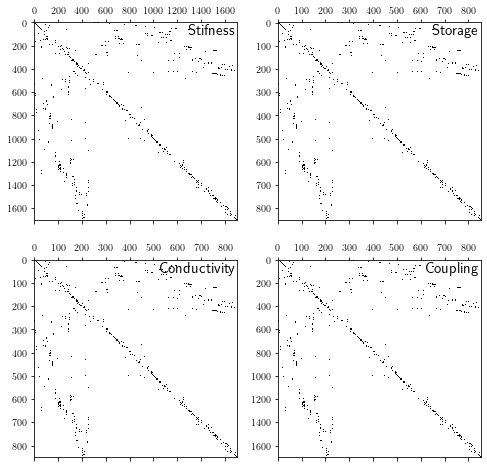

In [6]:
# Assembly of the different matrices
K = Matrix.assemble_stiffness_matrix(mesh, E, nu)
S = Matrix.assemble_mass_matrix(mesh, 1/M)
C = Matrix.assemble_conductivity_matrix(mesh, kappa)
Ce = Matrix.assemble_coupling_matrix(mesh, alpha)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
matrices = [K, S, C, Ce]
names = ['Stifness', 'Storage', 'Conductivity', 'Coupling']
for i, (ax, matrix) in enumerate(zip(axs.flatten(), (K, S, C, Ce))):
    ax.spy(matrix.toarray(), aspect='auto')
    ax.text(0.99, 0.99, names[i], size=15, va='top', ha='right', transform=ax.transAxes)

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Text(0.99, 0.99, 'T')

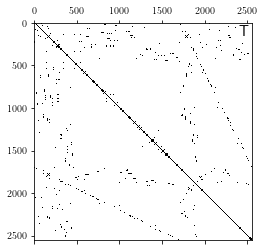

In [7]:
%matplotlib inline
# defining the single large matrix
dt = 0
AA = S + dt*C

ntot_E = mesh.nn*2
ntot_P = mesh.nn
ntot = ntot_E + ntot_P

T = csc_matrix((ntot, ntot))
T[:ntot_E, :ntot_E] = K
T[ntot_E:, :ntot_E] = -Ce.T
T[:ntot_E, ntot_E:] = -Ce
T[ntot_E:, ntot_E:] = -AA

plt.spy(T.toarray(), aspect=1)
plt.text(0.99, 0.99, 'T', size=15, va='top', ha='right', transform=plt.gca().transAxes)

### Boundary conditions
We impose a far field stress to the upper and right edges. From the symmetry of the problem, no horizontal displacement is possible on the left edge and no vertical displacement is possible on the bottom edge after the fracture.

Then, only the fracture lacks a boundary condition and we will test two possibilities:
- one where the fracture is impermeable and only a mechanical pressure is applied. Should the mechanical pressure be solely vertical or also horizontal? 
- one where the fracture is permeable; both a mechanical and a pore pressure are applied.

Proper dimensional analysis of the problem should tell us how we can properly define the pressure

In [8]:
## change parameters for the undrained ones!!!

# there won't be any vertical displacement for the nodes after the fracture
# we get the corresponding degree of freedom for the boundaries with no displacement
dof_left = 2*left
dof_bottom = 2*bottom_clear + 1
nodes_fixed = np.unique(np.hstack((left, bottom_clear)))
dof_fixed = np.unique(np.hstack((dof_left, dof_bottom)))

# we set the initial stress field
## how to properly enforce boundary conditions?
p0 = 0  # mean compressive
h0 = 0  # [Mpa]
h_frac = 100  # [MPa]

stress_field = -np.array([p0, p0, 0])
sigma = Matrix.set_stress_field(mesh, stress_field)
fx_right = np.sum(sigma[right * 2]) / box_length
fy_top = np.sum(sigma[top * 2 + 1]) / box_length

# we assemble the force vector
fx = Matrix.assemble_tractions_over_line(mesh, right, [fx_right, 0])
fy = Matrix.assemble_tractions_over_line(mesh, top, [0, fy_top])
ffrac = Matrix.assemble_tractions_over_line(mesh, bottom_frac, [h_frac, h_frac])
f = fx + fy - sigma + ffrac 

# we set the initial pore pressure field
pore_pressure_free = np.setdiff1d(np.arange(mesh.nn), bottom_frac)  # uncomment for permeable fracture 
#pore_pressure_free = np.arange(mesh.nn)  # uncomment for unpermeable fracture
pore_pressure_fixed = np.setdiff1d(np.arange(mesh.nn), pore_pressure_free)
h = np.zeros(mesh.nn)
h[pore_pressure_fixed] = h_frac
h[pore_pressure_free] = h0

# we can now build the parts of the equations that we want to solve
displacement_free = np.setdiff1d(np.arange(ntot_E), dof_fixed)
eq_free = np.hstack([displacement_free, pore_pressure_free + ntot_E])
eq_fixed = np.setdiff1d(np.arange(ntot), eq_free)

# setting the force vector to the initial conditions according to pore pressure
ftot = csc_matrix((ntot, 1))
ftot[:ntot_E] = f - Ce @ h
ftot[ntot_E:] = -AA @ h

# we solve the system
sol_undrained = csc_matrix((ntot, 1))
sol_undrained[eq_free] = linalg.inv(T[eq_free][:, eq_free]) @ ftot[eq_free]
sol_undrained[pore_pressure_fixed + ntot_E] = h_frac

displacement = sol_undrained.toarray()[:ntot_E, 0].reshape(2, -1, order='F')
pressure = sol_undrained.toarray()[ntot_E:, 0]

c:\Users\alexi\Desktop\2scool4cool\a2022\geomech\devoir\Element.py:245: RuntimeWarning: divide by zero encountered in true_divide
  DNaDX = DN/j
c:\Users\alexi\Desktop\2scool4cool\a2022\geomech\devoir\Element.py:245: RuntimeWarning: invalid value encountered in true_divide
  DNaDX = DN/j


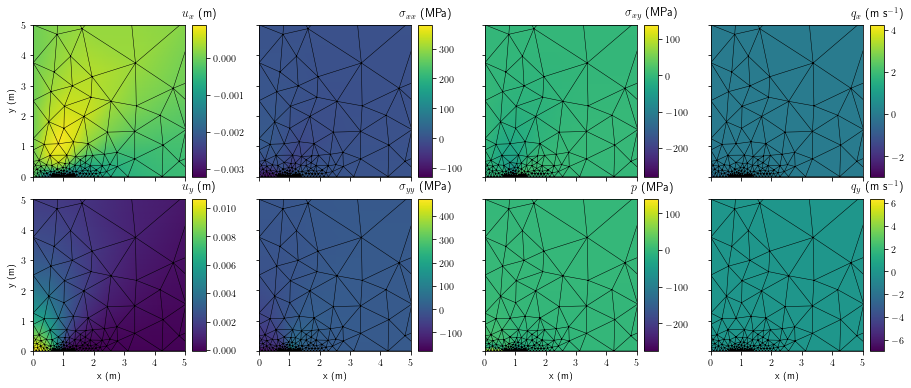

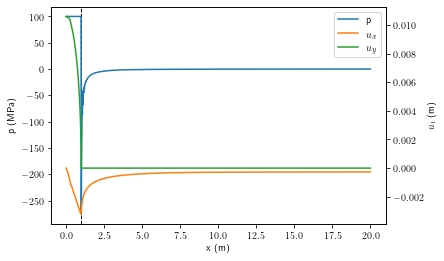

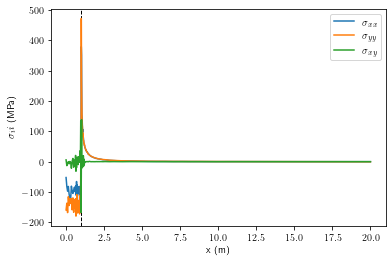

In [9]:
%matplotlib inline

# we want to look at the undrained behavior of the problem
du = Matrix.project_stress(mesh, E, nu, sol_undrained[:ntot_E].toarray())
dp = Matrix.project_flux(mesh, kappa, sol_undrained[ntot_E:].toarray())


# here we plot the many different fields
fig, axs = plt.subplots(2, 4, figsize=(16, 6), sharex='all', sharey='all')

_, _, cb = mesh.plot(displacement[0], ax=axs[0, 0])
cb.ax.set_title('$u_x$ (m)', rotation=0, ha='center', va='bottom')

_, _, cb = mesh.plot(displacement[1], ax=axs[1, 0])
cb.ax.set_title('$u_y$ (m)', rotation=0, ha='center', va='bottom')

_, _, cb = mesh.plot(du[0], ax=axs[0, 1])
cb.ax.set_title('$\sigma_{xx}$ (MPa)', rotation=0, ha='center', va='bottom')

_, _, cb = mesh.plot(du[1], ax=axs[1, 1])
cb.ax.set_title('$\sigma_{yy}$ (MPa)', rotation=0, ha='center', va='bottom')

_, _, cb = mesh.plot(du[2], ax=axs[0, 2])
cb.ax.set_title('$\sigma_{xy}$ (MPa)', rotation=0, ha='center', va='bottom')

_, _, cb = mesh.plot(pressure, ax=axs[1, 2])
cb.ax.set_title('$p$ (MPa)', rotation=0, ha='center', va='bottom')

_, _, cb = mesh.plot(dp[0], ax=axs[0, 3])
cb.ax.set_title('$q_x$ (m s$^{-1}$)', rotation=0, ha='center', va='bottom')

_, _, cb = mesh.plot(dp[1], ax=axs[1, 3])
cb.ax.set_title('$q_y$ (m s$^{-1}$)', rotation=0, ha='center', va='bottom')

axs[0, 0].set_xlim(0, 5*frac_length)
axs[0, 0].set_ylim(0, 5*frac_length)
[ax.set_aspect(1) for ax in axs.ravel()]
[ax.set_xlabel('x (m)') for ax in axs[-1, :]]
[ax.set_ylabel('y (m)') for ax in axs[:, 0]]
fig.subplots_adjust(hspace=0.15, wspace=0.05)

# we plot the pressure and displacement profile along the fracture
fig, ax = plt.subplots()
ax2 = ax.twinx()
X = mesh.nodes[bottom, 0]
ii = np.argsort(X)
l1, = ax.plot(X[ii], pressure[bottom][ii])
l2, = ax2.plot(X[ii], displacement[0, bottom][ii], c='tab:orange')
l3, = ax2.plot(X[ii], displacement[1, bottom][ii], c='tab:green')

ax.set_xlabel('x (m)')
ax.set_ylabel('p (MPa)')
ax2.set_ylabel('$u_i$ (m)')
ax.legend((l1, l2, l3), ('p', '$u_x$', '$u_y$'))
ax.axvline(1, ls='dashed', lw=1, c='k', zorder=0)

# we plot the different stress derivatives along the fracture
fig, ax = plt.subplots()
X = mesh.nodes[bottom, 0]
ii = np.argsort(X)
l1, = ax.plot(X[ii], du[0][bottom][ii])
l2, = ax.plot(X[ii], du[1][bottom][ii])
l3, = ax.plot(X[ii], du[2][bottom][ii])

ax.set_xlabel('x (m)')
ax.set_ylabel('$\sigma_ii$ (MPa)')

ax.legend((l1, l2, l3), ('$\sigma_{xx}$', '$\sigma_{yy}$', '$\sigma_{xy}$'))
ax.axvline(1, ls='dashed', lw=1, c='k', zorder=0)

### Time integration
Blablabla implicit


In [10]:
# we want to compute the time varying solution on log-spaced time intervals
t = np.logspace(-3, 6, 75)
dt = np.diff(t)

solutions = np.zeros((len(t), ntot))
solutions[0] = sol_undrained.toarray()[:, 0]

# do welinalg. want to keep on applying a mechanical pressure?
# comment this if we want to just apply a pore pressure
ftot = lil_matrix((ntot, 1))
ftot[ntot_E:] = -AA @ h

from time import time
print(eq_free)

t0 = time()
for i, dt_i in enumerate(dt):
    print(f'\rSolving {i+1}/{len(dt)} = {(i+1)/len(dt)*100:.2f}%. Total computation time: {time() - t0:.2f} s', end='')
    # we adjust the total matrix with a varying dt
    T[ntot_E:, ntot_E:] = -(S + dt_i * C)

    # the change in flux is adjusted
    flux = dt_i * C[pore_pressure_free].dot(solutions[i, ntot_E:])
    ftot[pore_pressure_free + ntot_E] = flux

    # we can solve the system
    update = linalg.spsolve(T[eq_free][:, eq_free], ftot[eq_free])
    solutions[i + 1, eq_free] = solutions[i, eq_free] + update
    solutions[i + 1 , pore_pressure_fixed + ntot_E] = h_frac
    
print('\nDing!')
# we can separate the displacements from the pore pressure to look at it
displacement_field = solutions[:, :ntot_E].reshape(len(t), 2, -1, order='F')
pore_pressure_field = solutions[:, ntot_E:]

[   1    2    3 ... 2550 2551 2552]
Solving 74/74 = 100.00%. Total computation time: 2.63 s
Ding!


(2427,)


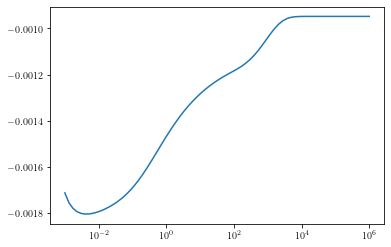

In [11]:
print(eq_free.shape)
%matplotlib inline
plt.semilogx(t, solutions[:, 10])

In [12]:
## here we compute the spatial derivatives step by step, could be improved a lot by keeping the same mass matrix
du = np.zeros((len(t), 3, mesh.nn))
dp = np.zeros((len(t), 2, mesh.nn))
t0 = time()
M = None

for i in range(len(t)):
    print(f'\rSolving {i+1}/{len(t)} = {(i+1)/len(t)*100:.2f}%. Total computation time: {time() - t0:.2f} s', end='')
    du[i], M = Matrix.project_stress(mesh, E, nu, solutions[i, :ntot_E][:, None], M=M, return_M=True)  # effective stress here
    dp[i] = Matrix.project_flux(mesh, kappa, solutions[i, ntot_E:][:, None], M=M, return_M=False)

Solving 1/75 = 1.33%. Total computation time: 0.00 s

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Solving 75/75 = 100.00%. Total computation time: 36.76 s

## Results
What does the displacements/pressure look like at the fracture during the period computed? What about the spatial derivatives, i.e. flux and stresses?

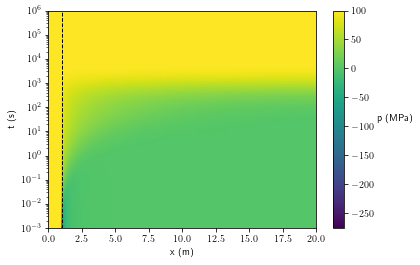

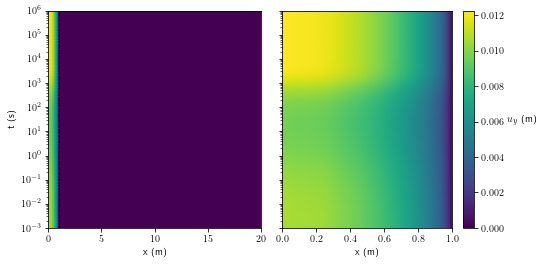

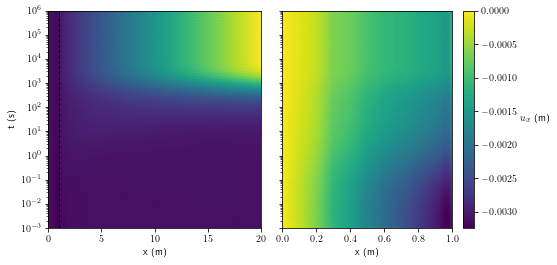

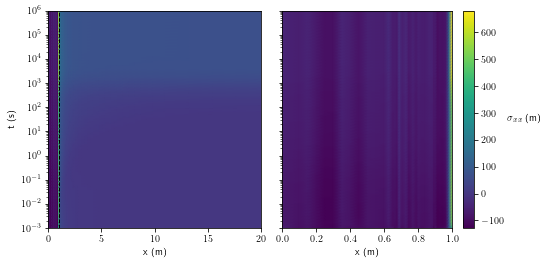

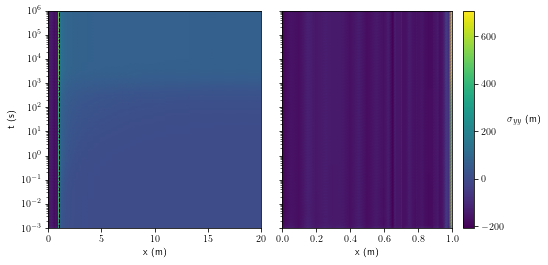

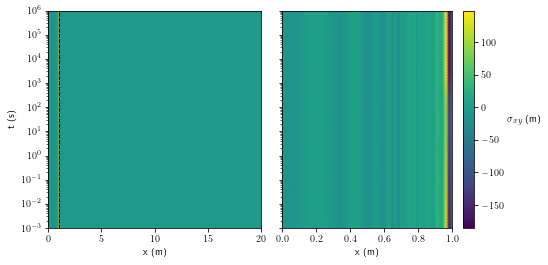

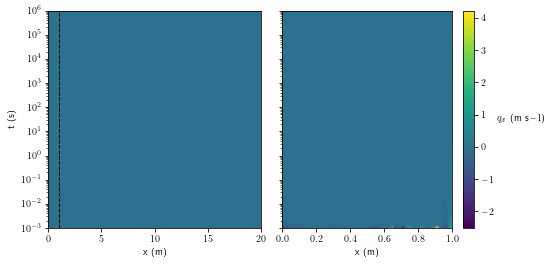

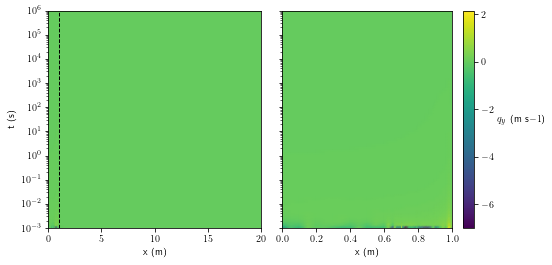

In [13]:
%matplotlib inline
# We create a few variables representing the pressure, displacement and so on
# We order them according to their x position
x = mesh.nodes[bottom, 0]
ii = x.argsort()
x = x[ii]
p = pore_pressure_field[:, bottom][:, ii]
u_x = displacement_field[:, 0][:, bottom][:, ii]
u_y = displacement_field[:, 1][:, bottom][:, ii]
sxx = du[:, 0][:, bottom][:, ii]
syy = du[:, 1][:, bottom][:, ii]
sxy = du[:, 2][:, bottom][:, ii]
qx = dp[:, 0][:, bottom][:, ii]
qy = dp[:, 1][:, bottom][:, ii]

# Pressure
plt.figure()
plt.pcolormesh(x, t, p, shading='gouraud')
plt.yscale('log')
cb = plt.colorbar()
cb.ax.set_ylabel('p (MPa)', rotation=0, ha='left', va='center')
plt.xlabel('x (m)')
plt.ylabel('t (s)')
plt.axvline(frac_length, c='k', lw=1, ls='dashed')

# Vertical displacement
fig, axs = plt.subplots(1, 2, sharey='row', figsize=(8, 4))
axs[0].pcolormesh(x, t, u_y, shading='gouraud')
im = axs[1].pcolormesh(x[x <= frac_length], t, u_y[:, x <= frac_length], shading='gouraud')
plt.yscale('log')
cb = plt.colorbar(im)
cb.ax.set_ylabel('$u_y$ (m)', rotation=0, ha='left', va='center')
[ax.set_xlabel('x (m)') for ax in axs]
axs[0].set_ylabel('t (s)')
axs[0].axvline(frac_length, c='k', lw=1, ls='dashed')
fig.subplots_adjust(wspace=0.1)

# Horizontal displacement
fig, axs = plt.subplots(1, 2, sharey='row', figsize=(8, 4))
axs[0].pcolormesh(x, t, u_x, shading='gouraud')
im = axs[1].pcolormesh(x[x <= frac_length], t, u_x[:, x <= frac_length], shading='gouraud')
plt.yscale('log')
cb = plt.colorbar(im)
cb.ax.set_ylabel('$u_x$ (m)', rotation=0, ha='left', va='center')
[ax.set_xlabel('x (m)') for ax in axs]
axs[0].set_ylabel('t (s)')
axs[0].axvline(frac_length, c='k', lw=1, ls='dashed')
fig.subplots_adjust(wspace=0.1)

# Horizontal stress
fig, axs = plt.subplots(1, 2, sharey='row', figsize=(8, 4))
axs[0].pcolormesh(x, t, sxx, shading='gouraud')
im = axs[1].pcolormesh(x[x <= frac_length], t, (sxx)[:, x <= frac_length], shading='gouraud')
plt.yscale('log')
cb = plt.colorbar(im)
cb.ax.set_ylabel('$\sigma_{xx}$ (m)', rotation=0, ha='left', va='center')
[ax.set_xlabel('x (m)') for ax in axs]
axs[0].set_ylabel('t (s)')
axs[0].axvline(frac_length, c='k', lw=1, ls='dashed')
fig.subplots_adjust(wspace=0.1)

# Vertical stress
fig, axs = plt.subplots(1, 2, sharey='row', figsize=(8, 4))
axs[0].pcolormesh(x, t, syy, shading='gouraud')
im = axs[1].pcolormesh(x[x <= frac_length], t, (syy)[:, x <= frac_length], shading='gouraud')
plt.yscale('log')
cb = plt.colorbar(im)
cb.ax.set_ylabel('$\sigma_{yy}$ (m)', rotation=0, ha='left', va='center')
[ax.set_xlabel('x (m)') for ax in axs]
axs[0].set_ylabel('t (s)')
axs[0].axvline(frac_length, c='k', lw=1, ls='dashed')
fig.subplots_adjust(wspace=0.1)

# Shear stress
fig, axs = plt.subplots(1, 2, sharey='row', figsize=(8, 4))
axs[0].pcolormesh(x, t, sxy, shading='gouraud')
im = axs[1].pcolormesh(x[x <= frac_length], t, (sxy)[:, x <= frac_length], shading='gouraud')
plt.yscale('log')
cb = plt.colorbar(im)
cb.ax.set_ylabel('$\sigma_{xy}$ (m)', rotation=0, ha='left', va='center')
[ax.set_xlabel('x (m)') for ax in axs]
axs[0].set_ylabel('t (s)')
axs[0].axvline(frac_length, c='k', lw=1, ls='dashed')
fig.subplots_adjust(wspace=0.1)

# Horizontal flux
fig, axs = plt.subplots(1, 2, sharey='row', figsize=(8, 4))
axs[0].pcolormesh(x, t, qx, shading='gouraud')
im = axs[1].pcolormesh(x[x <= frac_length], t, qx[:, x <= frac_length], shading='gouraud')
plt.yscale('log')
cb = plt.colorbar(im)
cb.ax.set_ylabel('$q_x$ (m s${-1}$)', rotation=0, ha='left', va='center')
[ax.set_xlabel('x (m)') for ax in axs]
axs[0].set_ylabel('t (s)')
axs[0].axvline(frac_length, c='k', lw=1, ls='dashed')
fig.subplots_adjust(wspace=0.1)

# Vertical flux
fig, axs = plt.subplots(1, 2, sharey='row', figsize=(8, 4))
axs[0].pcolormesh(x, t, qy, shading='gouraud')
im = axs[1].pcolormesh(x[x <= frac_length], t, qy[:, x <= frac_length], shading='gouraud')
plt.yscale('log')
cb = plt.colorbar(im)
cb.ax.set_ylabel('$q_y$ (m s${-1}$)', rotation=0, ha='left', va='center')
[ax.set_xlabel('x (m)') for ax in axs]
axs[0].set_ylabel('t (s)')
axs[0].axvline(frac_length, c='k', lw=1, ls='dashed')
fig.subplots_adjust(wspace=0.1)

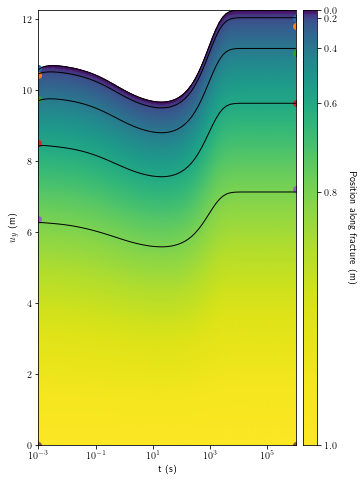

In [14]:
def analytical_disp(x, p0, c, nu, E):
    epsilon = 2*(1 - nu**2)*p0/c/E
    w = epsilon*np.sqrt(1 - (x/c)**2)
    return w

def analytical_stress(x, c, p0):
    z = x + 0j
    Z = p0 * (z/(np.sqrt(z**2 - c**2))-1)
    
    
# We also look at fracture width evolution for multiple distances along the fracture.

%matplotlib inline
uy_frac = u_y[:, x <= frac_length]*1000
x_frac = x[x <= frac_length]

xx, tt = np.meshgrid(x_frac, t)

from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(5, 8))
ax = plt.gca()
ax.pcolormesh(tt, uy_frac, xx, shading='gouraud')#, norm=LogNorm())
cb.ax.invert_yaxis()
cb.ax.set_yscale('log')
levels = np.linspace(0, 1, 6)
contours = plt.contour(tt, uy_frac, xx, levels=levels, colors='k', linewidths=1)
ax.set_xscale('log')
ax.set_xlabel('t (s)')
ax.set_ylabel('$u_y$ (m)')

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size=0.2, pad=0.1)
cax.yaxis.tick_right()
cax.yaxis.set_label_position("right")

cax.pcolormesh(tt[-3:-1, -1], uy_frac[-1, :], xx[-3:-1, :].T, shading='gouraud')
#cax.contour(tt[-3:-1, -1], uy_frac[-1, :], xx[-3:-1, :].T, levels=levels, colors='k', linewidths=1)

yticks = [uy_frac[-1, x_frac == l][0] for l in levels]

cax.set_yticks(yticks)
cax.set_yticklabels([f'${l:.1f}$' for l in levels])#, fmt=lambda t: f'{t:.2f}')
cax.set_ylabel('Position along fracture (m)', rotation=270, labelpad=20)
cax.set_xticks([])

undrained = analytical_disp(levels, h_frac, frac_length, nu_u, E_u) * 1000
drained = analytical_disp(levels, h_frac, frac_length, nu, E) * 1000

for i in range(len(levels)):
    ax.scatter([t[0], t[-1]], [undrained[i], drained[i]])


In [19]:

%matplotlib qt

plt.rcParams['text.usetex'] = False
from matplotlib.animation import FuncAnimation

# Some ANIMATIONS funky fresh
fig, ax = plt.subplots(figsize=(10, 10))
ax2 = ax.twinx()

l1, = ax.plot(x, p[0])
l2, = ax2.plot(x, u_y[0], c='tab:orange')
text = ax.set_title(f't = $10^{{{np.log10(t[0]):.2f}}}$ s')

ax2.plot(x_frac_long, undrained, c='k', ls='dashed')
ax2.plot(x_frac_long, drained, c='k', ls='dashed')

ax.axvline(frac_length, c='k', lw=1, ls='dashed')
#ax.text(frac_length*1.2, ax.get_ylim()[0], 'Fracture limit', ha='left', va='bottom')
ax.legend((l1, l2), ('p', '$u_y$'), frameon=False, loc='lower right')
ax.set_xlabel('x (m)')
ax2.set_ylabel('$u_y$ (m)', rotation=0, ha='left', va='center')
ax.set_ylabel('p (MPa)', rotation=0, ha='right', va='center')

pmax = np.abs(p).max()*1.1
ax.set_ylim(-pmax, pmax)

umax = np.abs(u_y).max()*1.1
ax2.set_ylim(-umax, umax)
times = [f't = $10^{{{np.log10(t[i]):.2f}}}$ s' for i in range(len(t))]

ax.set_xlim(0, 2*frac_length)

def update(i, l1, l2, t):
    l1.set_data(x, p[i])
    l2.set_data(x, u_y[i])
    text.set_text(times[i])
    return l1, l2, text,

ani = FuncAnimation(fig, update, frames=len(t), blit=False, interval=50, fargs=(l1, l2, t))
plt.tight_layout()
plt.show()

In [20]:
%matplotlib qt

from matplotlib.animation import FuncAnimation

# Some ANIMATIONS funky fresh
fig, ax = plt.subplots(figsize=(10, 10))

l1, = ax.plot(x, sxx[0], label='$\sigma_{xx}$')
l2, = ax.plot(x, syy[0], label='$\sigma_{yy}$')
l3, = ax.plot(x, sxy[0], label='$\sigma_{xy}$')
text = ax.set_title(f't = $10^{{{np.log10(t[0]):.2f}}}$ s')

ax.axvline(frac_length, c='k', lw=1, ls='dashed')
ax.legend(frameon=False, loc='lower right')
ax.set_xlabel('x (m)')
ax.set_ylabel('$\sigma_i$ (MPa)', rotation=0, ha='right', va='center')

smax = np.abs(syy).max()*1.1
ax.set_ylim(-smax, smax)
ax.text(frac_length*1.2, ax.get_ylim()[0], 'Fracture limit', ha='left', va='bottom')

def update(i, l1, l2, l3, t):
    l1.set_data(x, sxx[i])
    l2.set_data(x, syy[i])
    l3.set_data(x, sxy[i])
    text.set_text(f't = $10^{{{np.log10(t[i]):.2f}}}$ s')
    return l1, l2, l3, text,

ani = FuncAnimation(fig, update, frames=len(t), blit=False, interval=50, fargs=(l1, l2, l3, t))
plt.tight_layout()
plt.show()

In [25]:
%matplotlib qt

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
im = ax.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], pore_pressure_field[0], lw=1, shading='gouraud', 
                  vmin=pore_pressure_field.min(), vmax=pore_pressure_field.max())
norm = np.linalg.norm(dp, axis=1)
vec = ax.quiver(mesh.nodes[:, 0], mesh.nodes[:, 1], dp[0, 0]/norm[0], dp[0, 1]/norm[0], scale=1e2, alpha=0.3)

text = ax.set_title(f't = $10^{{{np.log10(t[0]):.2f}}}$ s', loc='left')
ax.set_xlim(0, box_length)
ax.set_ylim(0, box_length)
ax.text(0.99, 1.01, 'Pore pressure evolution', ha='right', va='bottom', transform=ax.transAxes)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

def update(i):
    text.set_text(f't = $10^{{{np.log10(t[i]):.2f}}}$ s')
    im.set_array(pore_pressure_field[i])
    vec.set_UVC(dp[i, 0]/norm[i], dp[i, 1]/norm[i])
    return im, time, vec

ani = FuncAnimation(fig, update, frames=len(t), blit=False, interval=50)

In [26]:
%matplotlib qt

ux = displacement_field[:, 0]
fig = plt.figure()
ax = fig.add_subplot()
im = ax.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], ux[0], lw=1, shading='gouraud')
text = ax.set_title(f't = $10^{{{np.log10(t[0]):.2f}}}$ s', loc='left')
ax.set_xlim(0, box_length)
ax.set_ylim(0, box_length)
ax.text(0.99, 1.01, '$u_x$ evolution', ha='right', va='bottom', transform=ax.transAxes)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

def update(i):
    text.set_text(f't = $10^{{{np.log10(t[i]):.2f}}}$ s')
    im.set_array(ux[i])
    return im, time

ani = FuncAnimation(fig, update, frames=len(t), blit=False, interval=50)

In [27]:
uy = displacement_field[:, 1]
fig = plt.figure()
ax = fig.add_subplot()
im = ax.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], uy[0], lw=1, shading='gouraud')
text = ax.set_title(f't = $10^{{{np.log10(t[0]):.2f}}}$ s', loc='left')
ax.set_xlim(0, box_length)
ax.set_ylim(0, box_length)
ax.text(0.99, 1.01, '$u_y$ evolution', ha='right', va='bottom', transform=ax.transAxes)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

def update(i):
    text.set_text(f't = $10^{{{np.log10(t[i]):.2f}}}$ s')
    im.set_array(uy[i])
    return im, time

ani = FuncAnimation(fig, update, frames=len(t), blit=False, interval=50)

In [28]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot()
im = ax.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], du[0, 0], lw=1, shading='gouraud')
text = ax.set_title(f't = $10^{{{np.log10(t[0]):.2f}}}$ s', loc='left')
ax.set_xlim(0, box_length)
ax.set_ylim(0, box_length)
ax.text(0.99, 1.01, '$\sigma_{xx}$ evolution', ha='right', va='bottom', transform=ax.transAxes)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

def update(i):
    text.set_text(f't = $10^{{{np.log10(t[i]):.2f}}}$ s')
    im.set_array(du[i, 0])
    return im, time

ani = FuncAnimation(fig, update, frames=len(t), blit=False, interval=50)

In [30]:
fig = plt.figure()
ax = fig.add_subplot()
im = ax.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], du[0, 1], lw=1, shading='gouraud')
text = ax.set_title(f't = $10^{{{np.log10(t[0]):.2f}}}$ s', loc='left')
ax.set_xlim(0, box_length)
ax.set_ylim(0, box_length)
ax.text(0.99, 1.01, '$\sigma_{yy}$ evolution', ha='right', va='bottom', transform=ax.transAxes)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

def update(i):
    text.set_text(f't = $10^{{{np.log10(t[i]):.2f}}}$ s')
    im.set_array(du[i, 1])
    return im, time

ani = FuncAnimation(fig, update, frames=len(t), blit=False, interval=50)

In [29]:
fig = plt.figure()
ax = fig.add_subplot()
im = ax.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], du[0, 2], lw=1, shading='gouraud')
text = ax.set_title(f't = $10^{{{np.log10(t[0]):.2f}}}$ s', loc='left')
ax.set_xlim(0, box_length)
ax.set_ylim(0, box_length)
ax.text(0.99, 1.01, '$\sigma_{xy}$ evolution', ha='right', va='bottom', transform=ax.transAxes)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

def update(i):
    text.set_text(f't = $10^{{{np.log10(t[i]):.2f}}}$ s')
    im.set_array(du[i, 2])
    return im, time

ani = FuncAnimation(fig, update, frames=len(t), blit=False, interval=50)